In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
from scipy.signal import convolve
import scipy
from joblib import Parallel, delayed
import time
import sys
from scipy import sparse
import json
from tqdm import tqdm, tqdm_notebook
import matplotlib.gridspec as gridspec
import os
sys.path.insert(0, "../Scripts")
# from antigenicWaveSimulationMethods import main as coEvoSimulation
from coverage import elementwise_coverage, coverage_1D
from fitness import fitness, norm_fitness, phage_growth
# from altImmunity import immunity_loss_uniform, immunity_gain_from_kernel
from immunity import immunity_mean_field_add, immunity_mean_field_remove
from initMethods import init_trail_nh, init_1D_kernel, init_guassian_n, init_cond
from supMethods import time_conv, write2json
from mutation import mutation
from randomHGT import HGT_logistic_event

from antigenicWaveSimulation1DMethods import main as coEvoSimulation
from antigenicWaveSimulation1DMethods import make_paramslists1D

In [2]:
params = { #parameters relevant for the equations
        "Nh":                     1E4,
        "N0":                     1E9, #This Will be updated by self-consitent solution
        "R0":                     100, 
        "M0":                       5, #Also L, total number of spacers
        "mu":                      10, #mutation rate
        "gamma_shape":             20,
        "Np":                     100, #Number of Cas Protein
        "dc":                      10, #Required number of complexes to activate defence
        "h":                       10, #coordination coeff
        "r":                     1000, #cross-reactivity kernel
        "beta":                     0,
        "rate_HGT":                 0,
        "HGT_bonus_acq_ratio":      0,
        "rate_recovery":            0,
        "HGT_type":                 0,
        "n_spacer":                 1,
        "A":                     0.01,
    }
sim_params = { #parameters relevant for the simulation (including Inital Valuess)
        "continue":                 False, #DO NOT CREATE ARBITRARY FOLDERS ONLY FOR TESTS
        "xdomain":                  50000,
        "dim":                          1,
        "dx":                           1,
        "tf":                        1000,
        "dt":                           1,
        "dt_exact_fitness":            50,
        "dt_snapshot":                 10,
        "initial_mean_n":           [0,0],
        "initial_mean_nh":          [0,0],
        "conv_size":                 2000,
        "num_threads":                 32,
        "foldername":       "../Data_1D_betaTest3",
        "seed":                         34,
        "hard_N0":                   False,
        "ndim":                         1,
    }

In [3]:
params, sim_params = init_cond(params, sim_params)
foldername = sim_params["foldername"]

try:
    write2json(foldername, params, sim_params)
except FileNotFoundError:
    os.mkdir(foldername)
    write2json(foldername, params, sim_params)


Assumptions Checks: 
mu >> 1 : mu = 10 >> 1
del_x << r : gamma_shape = 20 << r = 1000
v*tau >> sigma : v*tau = 652.1223664042368 >> sigma = 34.362053975935815
uc << r : uc = 125.49630306806367 << r = 1000
uc_delayed >> beta_sigma**2 : uc delayed = 125.49630306806367 >> beta_sigma**2 = 0.0


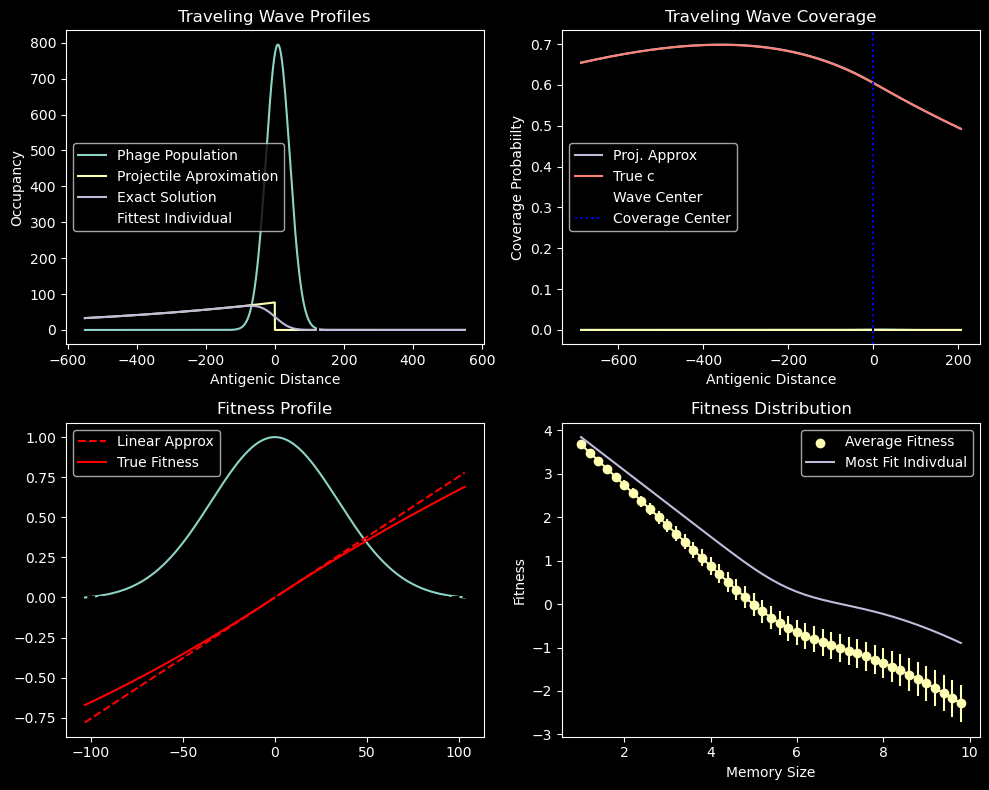

In [4]:
from formulas import plot_fitness_memory_dynamics, plot_wave_coverage, plot_wave_fitness, plot_wave_profiles
fig = plt.figure(figsize=(10, 8))

gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

plot_wave_profiles(params, sim_params, ax1)
plot_wave_coverage(params, sim_params, ax2)
plot_wave_fitness(params, sim_params, ax3)
plot_fitness_memory_dynamics(params, sim_params, ax4)

plt.tight_layout()
plt.show()

In [ ]:
#Single Simulation
res = coEvoSimulation(params, sim_params, False, False)

In [ ]:
#MultiCore Simulations

list_to_sweep_A = np.power(10, np.arange(-3., 3., 1))
params["mu"] = 0.001
params_list, sim_params_list = make_paramslists1D(params, sim_params, "A", list_to_sweep_A)

results = Parallel(n_jobs=32)(delayed(coEvoSimulation)
                (params, sim_params, False) for params, sim_params in zip(params_list, sim_params_list))

Simulation to be done with Num of Threads: 1 for Num of Seeds: 1 and Num of Points: 6
